## LSTM

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) architecture designed to handle sequence data, where each input can be a sequence of data points over time. LSTMs are particularly effective at capturing long-term dependencies in sequential data, which traditional RNNs can struggle with due to vanishing gradient problems.

### LSTM Architecture
<img src="./images/lstm/lstm-architecture.png" />

+ <b>Memory Cell</b>: The core component of an LSTM is the memory cell, which allows the network to store information over time. The cell maintains an internal state that can be updated or modified based on input data and previous states.
+ <b>Gates</b>: LSTMs utilize several gates to control the flow of information into and out of the memory cell:
  > Forget Gate: Determines which information from the previous cell state should be discarded or forgotten
  > Input Gate: Decides which new information from the current input should be stored in the memory cell.
  > Output Gate: Controls which information from the current cell state should be output as the final prediction.
+ <b>Forget Gate</b>: The forget gate takes as input the previous cell state 𝐶𝑡−1 and the current input 𝑥𝑡, and outputs a forget vector 𝑓𝑡 that determines how much of the previous cell state should be retained and how much should be forgotten.
+ <b>Input Gate</b>: The input gate takes as input the previous cell state 𝐶𝑡−1 and the current input 𝑥𝑡, and produces an input vector 𝐶~𝑡 that contains new candidate values to be added to the cell state.
+ <b>Update Cell State</b>: The forget gate 𝑓𝑡 is applied element-wise to the previous cell state 𝐶𝑡−1 to forget irrelevant information, and the input gate 𝑖𝑡 is applied element-wise to the input vector C~t to determine which new information to store. The resulting cell state is the combination of forgetting and adding new information.
+ <b>Output Gate</b>: The output gate takes as input the previous cell state 𝐶𝑡−1, the current input 𝑥𝑡, and the updated cell state 𝐶𝑡, and produces an output vector ℎ𝑡 that determines which information should be passed on to the next time step as the final prediction.

### Import Data

To develop an LSTM machine learning model, we utilize real estate data comprising listings from the city of Kitchener, Ontario. This dataset encapsulates the average prices of houses for sale in Kitchener, each annotated with a corresponding timestamp.

In [515]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("csv-files/Kitchener_Price_Trend.csv")
df = df.drop(['City'], axis=1)

In [516]:
df.index = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

<Axes: xlabel='timestamp'>

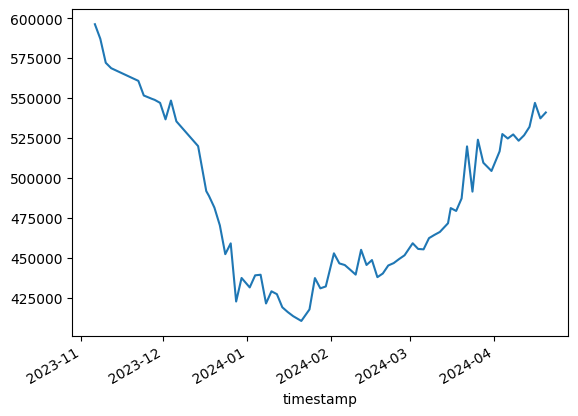

In [517]:
price = df['Price']
price.plot()

### What is Window-Size?
In the context of Long Short-Term Memory (LSTM) networks, window size typically refers to the number of time steps or sequence steps considered in each input sample.
### Organizing the data with Window Size
The function, df_to_X_y, converts a pandas DataFrame (df) containing time series data into input-output pairs suitable for training a machine learning model, particularly for LSTM (Long Short-Term Memory) models. It takes the DataFrame df, which contains the time series data, and another DataFrame dates containing corresponding timestamps.

The function also accepts a window_size parameter, which determines the number of consecutive time steps to consider as input for predicting the next time step. It defaults to 5 if not specified.

In [518]:
def df_to_X_y(df, dates, window_size=5):
    df_as_np = df.to_numpy()
    dates_as_np = dates.to_numpy()
    X = []
    y = []
    dates_array = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        date_row = dates_as_np[i+window_size]
        dates_array.append(date_row)
        y.append(label)
    return np.array(X), np.array(y), np.array(dates_array)

### WINDOW SIZE
In the context of Long Short-Term Memory (LSTM) networks, <b>window size</b> typically refers to the number of time steps or sequence steps considered in each input sample.

In [519]:
WINDOW_SIZE = 5
X, y, dates = df_to_X_y(df['Price'], df.index, WINDOW_SIZE)

### Normalizing the data


The <b>fit_transform</b> method in <b>scikit-learn's Scaler class</b> serves two purposes: fitting the scaler to the data and transforming the data using the fitted scaler. Here's a breakdown:

+ <b>Fitting</b>: When you call fit_transform on a scaler object (such as StandardScaler, MinMaxScaler, etc.), it internally computes the necessary statistics (e.g., mean and standard deviation for StandardScaler, minimum and maximum values for MinMaxScaler) from the data you provide. These statistics are used to scale or normalize the data.
+ <b>Transformation</b>: After fitting, the same method applies the scaling or normalization transformation to the data you provided. It rescales the data based on the statistics computed during the fitting step. This ensures that the data is transformed consistently based on the same scaling factors derived from the training data.

In [520]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the input data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
Y_scaled = scaler.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

In [521]:
X_scaled.shape, Y_scaled.shape

((69, 5, 1), (69,))

In [522]:
sixty_percent = round(Y_scaled.size*0.6)
eighty_percent = round(Y_scaled.size*0.8)
x_train, y_train, train_dates = X_scaled[:sixty_percent], Y_scaled[:sixty_percent], dates[:sixty_percent]
x_valid, y_valid, valid_dates = X_scaled[sixty_percent:eighty_percent], Y_scaled[sixty_percent:eighty_percent], dates[sixty_percent:eighty_percent]
x_test, y_test, test_dates = X_scaled[eighty_percent:], Y_scaled[eighty_percent:], dates[eighty_percent:]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((41, 5, 1), (41,), (14, 5, 1), (14,), (14, 5, 1), (14,))

### Utilizing Tensorflow with the use of GPU
Importing tensorflow to prepare the LSTM ML model, using tenorflow with a GPU accelerates deep learning computations, resulting in significantly faster training times compared to using only a CPU. 

In [523]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


The function <b>train_model</b>, is used to train a neural network model, particularly designed for time series data, with specified parameters. Here's a brief summary of what the function does:

+ <b>Model Architecture Setup</b>: It creates a sequential neural network model using Keras' Sequential API. The model starts with an input layer that expects input data of shape (window_size, 1), where window_size represents the number of time steps in each input sequence.
+ <b>LSTM Layer</b>: It adds an LSTM layer to the model with the specified number of LSTM nodes (lstm_num_nodes). The return_sequences=True parameter indicates that the LSTM layer should return the full sequence of outputs instead of just the last output. Dropout regularization is applied with the specified dropout rate (dropout).
+ <b>Dense Layers</b>: Two dense (fully connected) layers are added to the model. The first dense layer has num_nodes nodes and uses the ReLU activation function. The second dense layer has a single node and uses the linear activation function, suitable for regression tasks.
+ <b>Model Summary</b>: It prints a summary of the model architecture, displaying the number of parameters and the output shape of each layer.
+ <b>Model Compilation</b>: The model is compiled with a mean squared error loss function (MeanSquaredError()) and the Adam optimizer with the specified learning rate (learning_rate). Additionally, it tracks the root mean squared error (RootMeanSquaredError()) as a metric.
+ <b>Model Training</b>: The model is trained using the provided training data (x_train, y_train) for the specified number of epochs (epochs) and batch size (batch_size). Validation data (x_valid, y_valid) can also be provided to monitor model performance during training. A model checkpoint callback (ModelCheckpoint) is used to save the best-performing model during training.
+ <b>Return</b>: The trained model and the training history (which includes metrics and loss values during training) are returned from the function.

In [524]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

def train_model(x_train, y_train, window_size, lstm_num_nodes, dropout, num_nodes, learning_rate, batch_size, epochs):
    model = Sequential()
    model.add(InputLayer((window_size, 1)))
    model.add(LSTM(lstm_num_nodes, return_sequences=True, dropout=dropout))
    model.add(Dense(num_nodes, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    cp = ModelCheckpoint('./model.keras', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), 
                metrics=[RootMeanSquaredError()])
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                epochs=epochs, batch_size=batch_size, callbacks=[cp], verbose=0)
    return model, history

The function <b>plot_history</b>, is used to visualize the training history of a neural network model. It takes the history object returned by the fit function when training a Keras model in TensorFlow.

In [469]:
import matplotlib.pyplot as plt


def plot_history(history):
    # Figure Configuration to show two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    # Plot one to visualize the loss from the history
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Squared Error')
    ax1.grid(True)
    ax1.legend(['Loss', 'Val_Loss'])
    # Plot two to visualize the root mean squared error from the history
    ax2.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    ax2.plot(history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('root_mean_squared_error')
    ax2.grid(True)
    ax2.legend(['Loss', 'Val_Loss'])
    plt.show()

In [360]:
model, history = train_model(x_train, y_train, WINDOW_SIZE, 128, 0, 8, 0.001, 4, 60)

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                  │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 5, 8)           │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 5, 1)           │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,601 (264.07 KB)

 Trainable params: 67,601 (264.07 KB)

 Non-trainable params: 0 (0.00 B)

#### MEAN SQUARED ERROR
<b>Mean Squared Error (MSE)</b> in the context of <b>LSTM networks</b> is a common loss function used to measure the difference between predicted and actual values in regression tasks.

In an LSTM model, MSE is calculated by taking the average of the squared differences between the <b>predicted output values</b> and the corresponding <b>ground truth values</b> over a set of samples or time steps. It is often used as the loss function during the training phase to optimize the model's parameters.

#### ROOT MEAN SQUARED ERROR

<b>The Root Mean Squared Error (RMSE)</b> is a commonly used metric to evaluate the performance of <b>regression models</b>, including those built using <b>LSTM networks</b>.

In the context of LSTM models, RMSE measures the average magnitude of the errors between <b>predicted</b> and <b>actual values</b> in a time series prediction task.

MSE is calculated by taking the average of the squared differences between predicted values and actual values, whereas RMSE is calculated by taking the square root of the MSE. This makes the RMSE value directly comparable to the scale of the target variable.

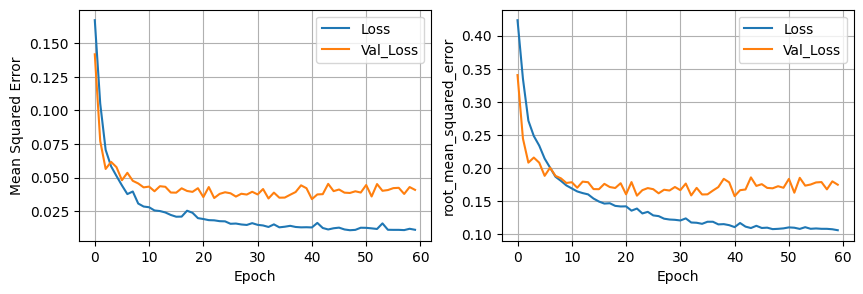

In [511]:
plot_history(history)

#### Analyzing Predictions with training data

In [525]:
y_train = y_train.reshape(y_train.shape[0], -1)
train_predict = model.predict(y_train)
train_predict_reshape = train_predict.reshape(1, -1)
train_predict_result = scaler.inverse_transform(train_predict_reshape)

y_train_reshape = y_train.reshape(1, -1)
y_train_result = scaler.inverse_transform(y_train_reshape)
train_results = pd.DataFrame(data={'Train Predictions':train_predict_result.flatten(), 'Actuals':y_train_result.flatten()})
train_results.index = pd.to_datetime(train_dates, format='%Y-%m-%d %H:%M:%S')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(array([19692., 19706., 19723., 19737., 19754., 19768.]),
 [Text(19692.0, 0, '2023-12-01'),
  Text(19706.0, 0, '2023-12-15'),
  Text(19723.0, 0, '2024-01-01'),
  Text(19737.0, 0, '2024-01-15'),
  Text(19754.0, 0, '2024-02-01'),
  Text(19768.0, 0, '2024-02-15')])

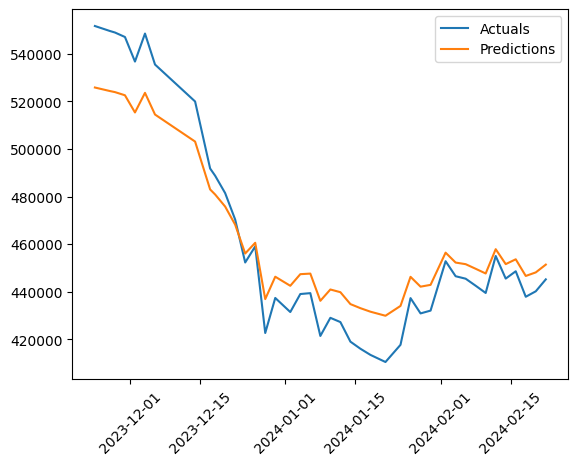

In [526]:
plt.plot(train_results['Actuals'])
plt.plot(train_results['Train Predictions'])
plt.legend(['Actuals', 'Predictions'])
plt.xticks(rotation=45)

#### Analyzing Predictions with validation data

In [527]:
y_valid = y_valid.reshape(y_valid.shape[0], -1)
valid_predict = model.predict(y_valid)
valid_predict_reshape = valid_predict.reshape(1, -1)
valid_predict_result = scaler.inverse_transform(valid_predict_reshape)

y_valid_reshape = y_valid.reshape(1, -1)
y_valid_result = scaler.inverse_transform(y_valid_reshape)
valid_results = pd.DataFrame(data={'Valid Predictions':valid_predict_result.flatten(), 'Actuals':y_valid_result.flatten()})
valid_results.index = pd.to_datetime(valid_dates, format='%Y-%m')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(array([19778., 19782., 19783., 19787., 19791., 19795., 19799., 19803.]),
 [Text(19778.0, 0, '2024-02-25'),
  Text(19782.0, 0, '2024-02-29'),
  Text(19783.0, 0, '2024-03-01'),
  Text(19787.0, 0, '2024-03-05'),
  Text(19791.0, 0, '2024-03-09'),
  Text(19795.0, 0, '2024-03-13'),
  Text(19799.0, 0, '2024-03-17'),
  Text(19803.0, 0, '2024-03-21')])

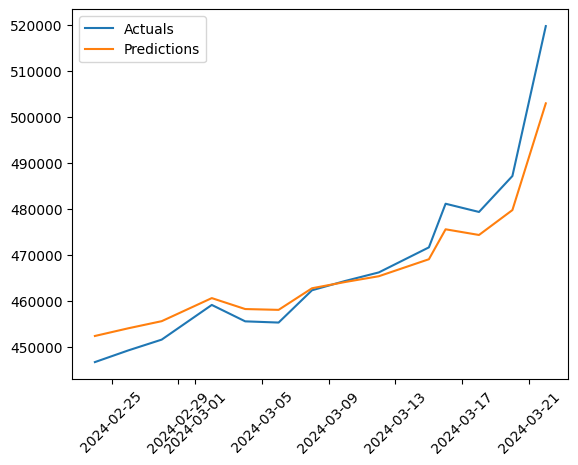

In [528]:
plt.plot(valid_results['Actuals'])
plt.plot(valid_results['Valid Predictions'])
plt.legend(['Actuals', 'Predictions'])
plt.xticks(rotation=45)

#### Analyzing Predictions with testing data

In [529]:
y_test = y_test.reshape(y_test.shape[0], -1)
test_predict = model.predict(y_test)
test_predict_reshape = test_predict.reshape(1, -1)
test_predict_result = scaler.inverse_transform(test_predict_reshape)

y_test_reshape = y_test.reshape(1, -1)
y_test_result = scaler.inverse_transform(y_test_reshape)
test_results = pd.DataFrame(data={'Test Predictions':test_predict_result.flatten(), 'Actuals':y_test_result.flatten()})
test_results.index = pd.to_datetime(test_dates, format='%Y-%m')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


(array([19807., 19811., 19814., 19818., 19822., 19826., 19830., 19834.]),
 [Text(19807.0, 0, '2024-03-25'),
  Text(19811.0, 0, '2024-03-29'),
  Text(19814.0, 0, '2024-04-01'),
  Text(19818.0, 0, '2024-04-05'),
  Text(19822.0, 0, '2024-04-09'),
  Text(19826.0, 0, '2024-04-13'),
  Text(19830.0, 0, '2024-04-17'),
  Text(19834.0, 0, '2024-04-21')])

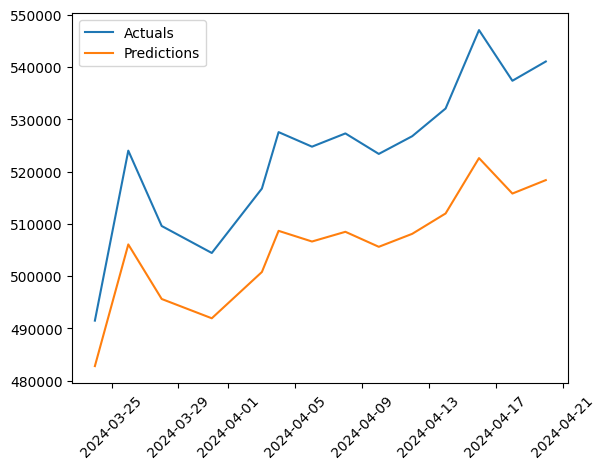

In [530]:
plt.plot(test_results['Actuals'])
plt.plot(test_results['Test Predictions'])
plt.legend(['Actuals', 'Predictions'])
plt.xticks(rotation=45)

### Predicting Future Values 

Following steps are used to analyze future values:

+ <b>Setting Parameters</b>:
 n_lookback: Represents the number of previous time steps to consider as input features for prediction.
 n_forecast: Indicates the number of future time steps to forecast.
+ <b>Extracting Input Data (X_)</b>:
It selects the last n_lookback data points (Y_scaled[-n_lookback:]) from the scaled target variable (Y_scaled), presumably representing the recent history of the time series.
Then, it reshapes the extracted data into the format expected by the model, with dimensions (1, n_lookback).
+ <b>Making Predictions (Y_)</b>:
It uses the trained machine learning model (model.predict) to forecast the next n_forecast time steps based on the input data (X_).
The predictions are reshaped into a column vector using .reshape(-1, 1).
+ <b>Inverse Scaling (scaler.inverse_transform)</b>:
It applies inverse scaling to the predicted values (Y_) to convert them back to the original scale of the target variable.
scaler refers to the scaler object used to scale the target variable during preprocessing.

In [531]:
n_lookback = 10
n_forecast = 10
X_ = Y_scaled[-n_lookback:]
X_ = X_.reshape(1, -n_lookback)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/tmp/ipykernel_46/2376920811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]


(array([19662., 19692., 19723., 19754., 19783., 19814., 19844.]),
 [Text(19662.0, 0, '2023-11'),
  Text(19692.0, 0, '2023-12'),
  Text(19723.0, 0, '2024-01'),
  Text(19754.0, 0, '2024-02'),
  Text(19783.0, 0, '2024-03'),
  Text(19814.0, 0, '2024-04'),
  Text(19844.0, 0, '2024-05')])

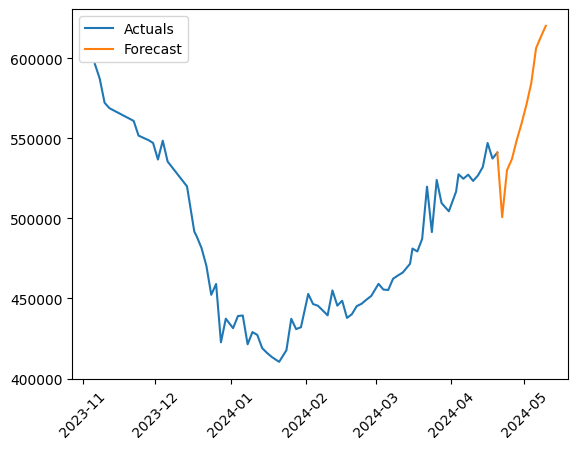

In [532]:
df_past = df['Price'].reset_index()
df_past.rename(columns={'index': 'timestamp', 'Price': 'Actual'}, inplace=True)
df_past['timestamp'] = pd.to_datetime(df_past['timestamp'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['timestamp', 'Actual', 'Forecast'])
df_future['timestamp'] = pd.date_range(start=df_past['timestamp'].iloc[-1] + pd.Timedelta(days=2), freq ='2D', periods=n_forecast)
df_future['Forecast'] = pd.DataFrame(Y_.flatten())
df_future['Actual'] = np.nan
forecast_results = pd.concat([df_past, df_future])
forecast_results.index = pd.to_datetime(forecast_results['timestamp'], format='%Y-%m-%d %H:%M:%S')
plt.plot(forecast_results['Actual'])
plt.plot(forecast_results['Forecast'])
plt.legend(['Actuals', 'Forecast'])
plt.xticks(rotation=45)